# Internet Traffic Network Analysis
By Jacob Laframboise

In [1]:
import os, sys
import time
import pandas as pd
import numpy as np
import scipy.sparse as sp
import networkx as nx
import matplotlib.pyplot as plt
import collections
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import scapy.all as scapy
import geoip2.database


## Load Data

In [2]:
# geo database file
geoDataPath = '..//database/GeoLite2-Country_20210928/GeoLite2-Country.mmdb'
# saved packet capture file
packets_fname = "../database/sample_pcaps/gov-websites-cap1.pcapng"


In [3]:
# load packets
# from file
packets = scapy.rdpcap(packets_fname)
# or live
# packets = scapy.sniff(count=1000, iface="enp39s0", filter="ip")

In [4]:
packets[0]

<Ether  dst=01:00:5e:00:00:16 src=2c:f0:5d:94:a4:22 type=IPv4 |<IP  version=4 ihl=6 tos=0xc0 len=40 id=0 flags=DF frag=0 ttl=1 proto=igmp chksum=0x4257 src=192.168.0.250 dst=224.0.0.22 options=[<IPOption_Router_Alert  copy_flag=1 optclass=control option=router_alert length=4 alert=router_shall_examine_packet |>] |<Raw  load='"\x00\\xfb\x02\x00\x00\x00\x01\x02\x00\x00\x00\\xe0\x00\x00\\xfb' |>>>

### Parameters

In [5]:
threshold = 0.0

## Create Graph

In [6]:
G = nx.Graph()

In [7]:
prev_packet_time = 0
prev_src = None
prev_dest = None

for i in range(len(packets)):
    packet = packets[i]
    try:
        ip_packet = packet[scapy.IP]
        src = ip_packet.src
        dest = ip_packet.dst
        t =packet.time
        if t - prev_packet_time < threshold:
            if src!=prev_src:
                G.add_edge(src, prev_src)
            if dest!=prev_dest:
                G.add_edge(dest, prev_dest)
            if src != prev_dest:
                G.add_edge(src, prev_dest)
            if dest!= prev_src:
                G.add_edge(dest, prev_src)
            
            
        G.add_edge(src, dest)
        
        prev_src = src
        prev_dest = dest
        prev_packet_time = t

    except IndexError:
#         print("skipped packet with no IP layer")
        continue

In [8]:
G.number_of_edges()

117

In [9]:
G.number_of_nodes()

109

In [10]:
sub_lengths = [len(x) for x in list(nx.connected_components(G))]
sorted(sub_lengths, reverse=True)[:10]

[105, 4]

### Filter to largest connected subgraph

In [11]:
largest_connected_subgraph_nodes = max(nx.connected_components(G), key=len)

In [12]:
G = G.subgraph(largest_connected_subgraph_nodes).copy()

## Network Analysis and Statistics

In [13]:
node_count = G.number_of_nodes()
edge_count = G.number_of_edges()
average_degree = sum(dict(nx.degree(G)).values()) / G.number_of_nodes()
radius = nx.radius(G)
diameter = nx.diameter(G)
density = nx.density(G)
print("Network Statistics:")
print("Number of nodes = {}".format(node_count))
print("Number of edges = {}".format(edge_count))
print("Average degree of nodes = {}".format(average_degree))
print("Radius of network = {}".format(radius))
print("Diameter of network = {}".format(diameter))
print("Density of network = {}".format(density))

Network Statistics:
Number of nodes = 105
Number of edges = 114
Average degree of nodes = 2.1714285714285713
Radius of network = 3
Diameter of network = 6
Density of network = 0.020879120879120878


In [14]:
degrees = sorted(dict(nx.degree(G)).values(), reverse=True)
degree_counter = collections.Counter(degrees)
degree, count = list(zip(*list(degree_counter.items())))

### Plot degree distribution

Text(0, 0.5, 'Count')

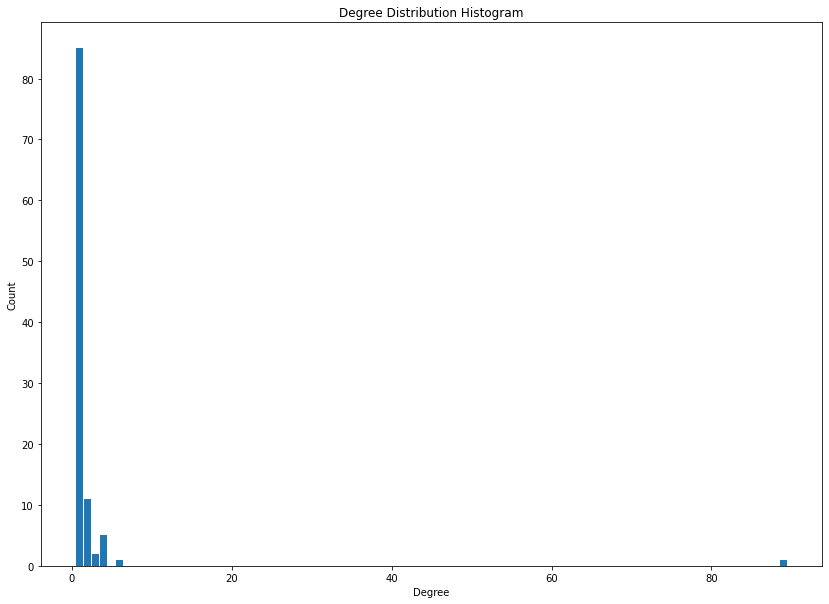

In [15]:
plt.figure(figsize=(14,10))
plt.bar(degree, count)

plt.title("Degree Distribution Histogram")
plt.xlabel("Degree")
plt.ylabel("Count")

## Compute Centralities of each IP

In [16]:
degree_centralities = nx.degree_centrality(G)
eigen_centralities = nx.eigenvector_centrality(G, max_iter=1000)
close_centralities = nx.closeness_centrality(G)

In [17]:
top4nodes_by_degree_centrality = sorted(degree_centralities.items(), key=lambda x: x[1], reverse=True)[:4]
top4nodes_by_eigen_centrality = sorted(eigen_centralities.items(), key=lambda x: x[1], reverse=True)[:4]
top4nodes_by_close_centrality = sorted(close_centralities.items(), key=lambda x: x[1], reverse=True)[:4]

In [18]:
for i in range(len(top4nodes_by_degree_centrality)):
    packet = top4nodes_by_degree_centrality[i]
    print("Central packet #{}:".format(i+1))
    print(packet)

Central packet #1:
('192.168.0.250', 0.8557692307692308)
Central packet #2:
('224.0.0.251', 0.057692307692307696)
Central packet #3:
('224.0.0.22', 0.038461538461538464)
Central packet #4:
('239.255.255.250', 0.038461538461538464)


In [19]:
for i in range(len(top4nodes_by_degree_centrality)):
    packet = top4nodes_by_eigen_centrality[i]
    print("Central packet #{}:".format(i+1))
    print(packet)

Central packet #1:
('192.168.0.250', 0.7044619476705904)
Central packet #2:
('199.127.204.162', 0.09190595373223286)
Central packet #3:
('192.168.0.1', 0.08526052791260723)
Central packet #4:
('224.0.0.22', 0.08524231520340812)


In [20]:
for i in range(len(top4nodes_by_degree_centrality)):
    packet = top4nodes_by_close_centrality[i]
    print("Central packet #{}:".format(i+1))
    print(packet)

Central packet #1:
('192.168.0.250', 0.7819548872180451)
Central packet #2:
('224.0.0.22', 0.48826291079812206)
Central packet #3:
('192.168.0.1', 0.48372093023255813)
Central packet #4:
('195.244.31.11', 0.4444444444444444)


In [21]:
centralities = pd.DataFrame([degree_centralities, eigen_centralities, close_centralities]).T
centralities.columns = ['Degree Centrality', 'Eigen Centrality', 'Closeness Centrality']

array([[<AxesSubplot:title={'center':'Degree Centrality'}>,
        <AxesSubplot:title={'center':'Eigen Centrality'}>],
       [<AxesSubplot:title={'center':'Closeness Centrality'}>,
        <AxesSubplot:>]], dtype=object)

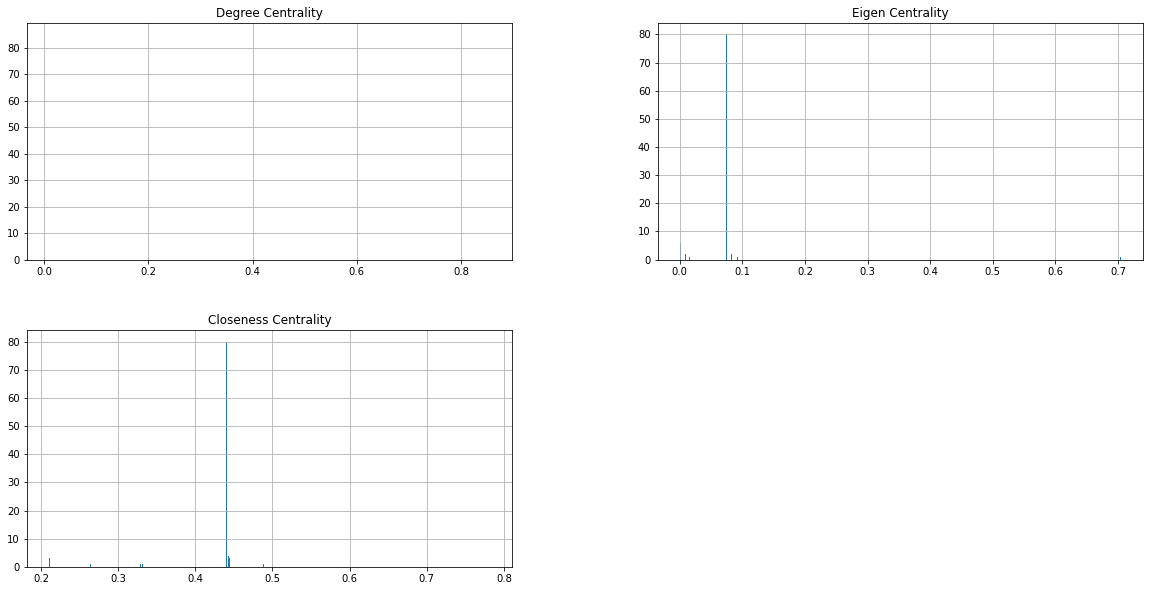

In [22]:
centralities.hist(bins=1000, figsize=(20,10))

Text(0.5, 0, 'Centrality')

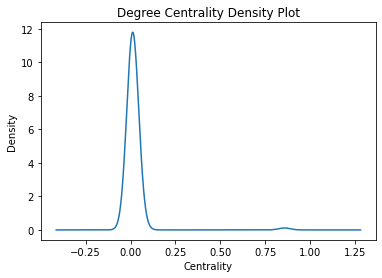

In [23]:
centralities['Degree Centrality'].plot.kde()
plt.title("Degree Centrality Density Plot")
plt.xlabel("Centrality")

Text(0.5, 0, 'Centrality')

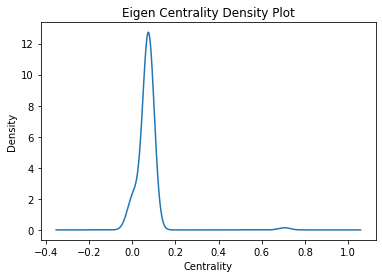

In [24]:
centralities['Eigen Centrality'].plot.kde()
plt.title("Eigen Centrality Density Plot")
plt.xlabel("Centrality")

Text(0.5, 0, 'Centrality')

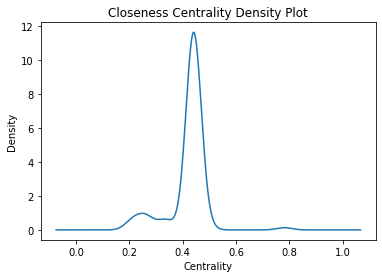

In [25]:
centralities['Closeness Centrality'].plot.kde()
plt.title("Closeness Centrality Density Plot")
plt.xlabel("Centrality")

## Visualize the graph networks

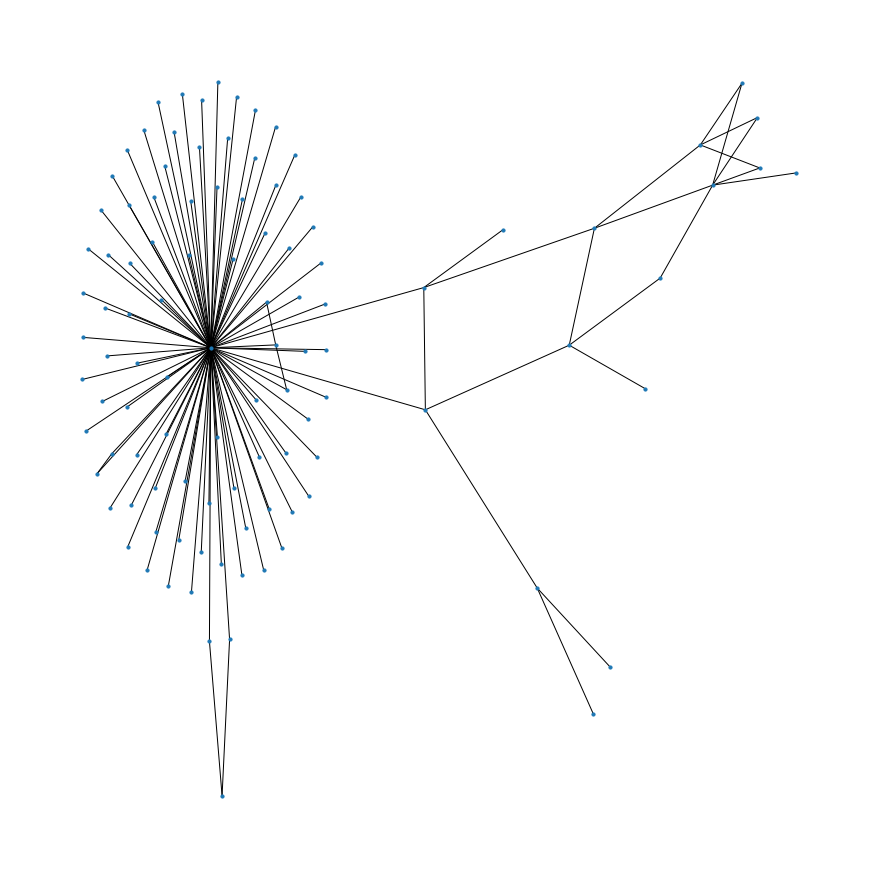

In [26]:
plt.figure(figsize=(12,12))
nx.draw(G, node_size=10)

## Visualize without our IP

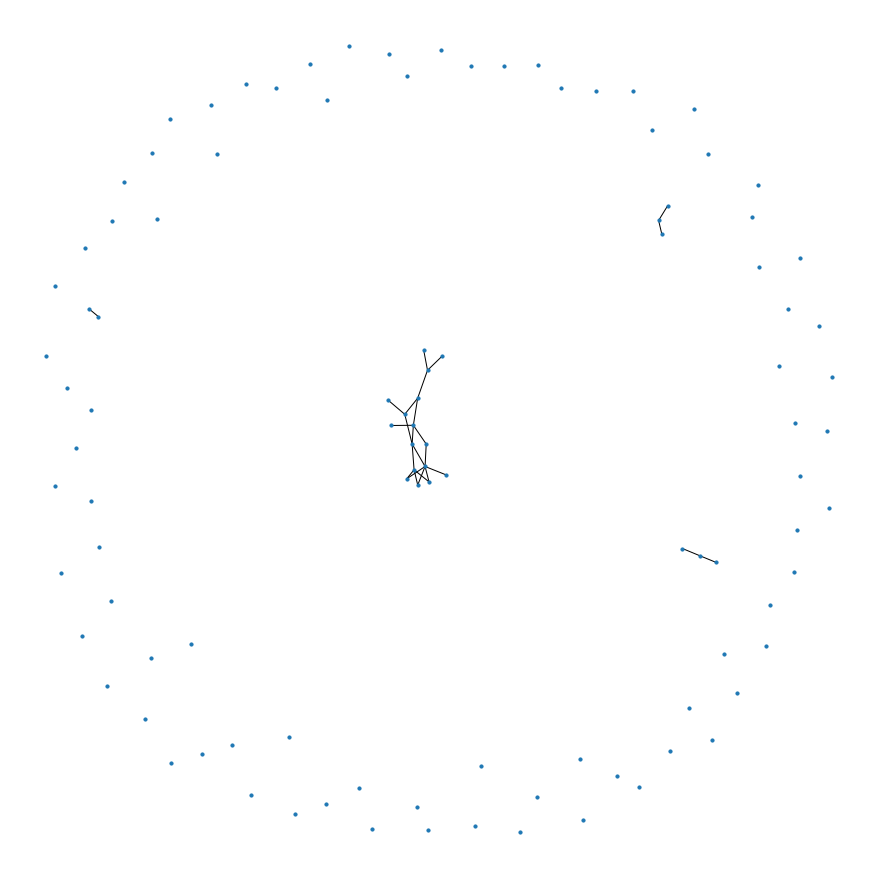

In [27]:
# drop our IP
plt.figure(figsize=(12,12))
nx.draw(G.subgraph([x for x in G.nodes if x!= '192.168.0.250']), node_size=10)

In [28]:
largest_connected_subgraph_nodes = max(nx.connected_components(G.subgraph([x for x in G.nodes if x!= '192.168.0.250'])), key=len)

In [29]:
Gs = G.subgraph(largest_connected_subgraph_nodes).copy()

# Visualize the largest connected cluster without our IP

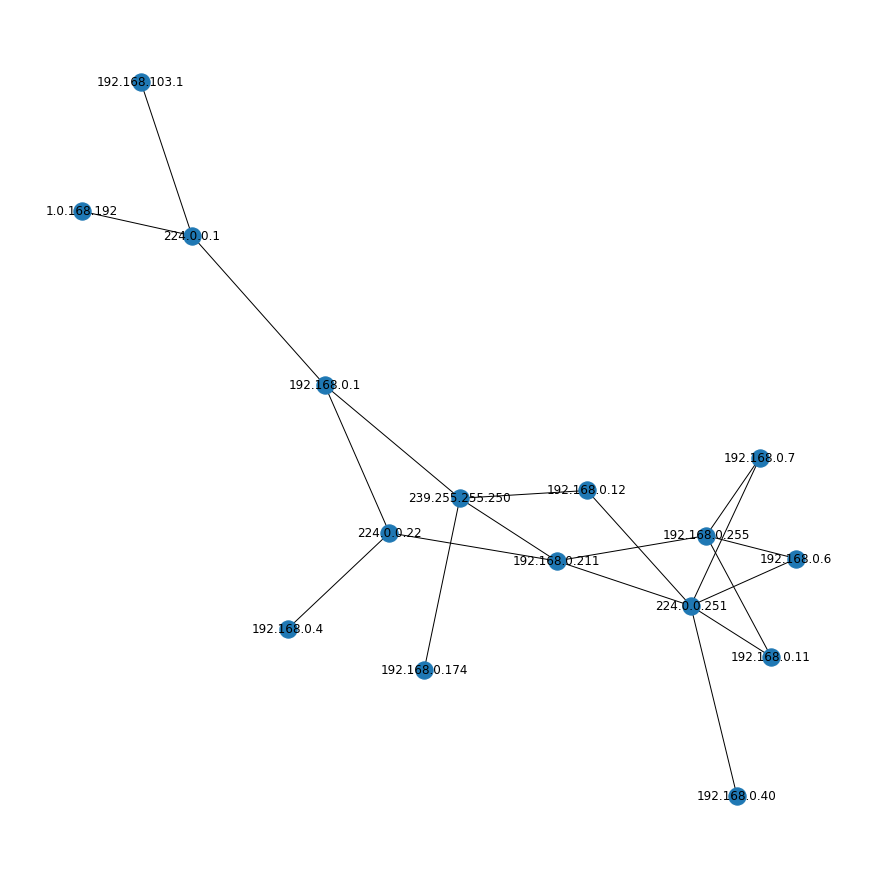

In [30]:
plt.figure(figsize=(12,12))
nx.draw(Gs, with_labels=True)